In [1]:
# N-CryptoAsset Portfolios: Identifying Highly Correlated 
# Cryptocurrencies using PCA
#
# (c) 2017 QuantAtRisk.com, by Pawel Lachowicz
 
 
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
 
# define some custom colours
grey = .6, .6, .6
 
 
def timestamp2date(timestamp):
    # function converts a Unix timestamp into Gregorian date
    return datetime.fromtimestamp(int(timestamp)).strftime('%Y-%m-%d')
 
def date2timestamp(date):
    # function coverts Gregorian date in a given format to timestamp
    return datetime.strptime(date_today, '%Y-%m-%d').timestamp()
 
def fetchCryptoClose(fsym, tsym):
    # function fetches the close-price time-series from cryptocompare.com
    # it may ignore USDT coin (due to near-zero pricing)
    # daily sampled
    cols = ['date', 'timestamp', fsym]
    lst = ['time', 'open', 'high', 'low', 'close']
    timestamp_today = datetime.today().timestamp()
    curr_timestamp = timestamp_today
 
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + "&limit=2000"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    tmp.append(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):  # remove for USDT
                tmp = np.array(tmp)
                tmp = tmp[[0,1,4]]  # filter solely for close prices
                df.loc[len(df)] = np.array(tmp)
        # ensure a correct date format
        df.index = pd.to_datetime(df.date, format="%Y-%m-%d")
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.ix[0][0])
        if(j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)
    data.drop("timestamp", axis=1, inplace=True)
 
    return data  # DataFrame

In [20]:
data.tail

<bound method NDFrame.tail of                    BTC     ETH    DASH     XMR     XRP    LTC    ETC     XEM  \
date                                                                           
2010-07-17     0.04951     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-18     0.05941     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-19     0.07723     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-20     0.07426     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-21     0.06634     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-22     0.05050     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-23     0.05050     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-24     0.05049     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-25     0.05050     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-26     0.05000     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-27

In [30]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.plotly as py
from plotly.graph_objs import *
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.plot(fig, filename = 'Cryptocurrency PAC',  fileopt ='overwrite')


In [31]:
data.replace(0, np.nan, inplace=True)

In [32]:
df_scatter(data, 'Cryptocurrency prices')

The draw time for this plot will be slow for clients without much RAM.


C:\Anaconda3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [2]:
# N-Cryptocurrency Portfolio (tickers)
fsym = ['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 'ETC', 'XEM', 'REP', 
        'MAID', 'ZEC', 'STEEM', 'GNT', 'FCT', 'ICN', 'DGD', 
        'WAVES', 'DCR', 'LSK', 'DOGE', 'PIVX']
# vs. 
tsym = 'USD'

In [3]:
for e in enumerate(fsym):
    print(e[0], e[1])
    if(e[0] == 0):
        try:
            data = fetchCryptoClose(e[1], tsym)
        except:
            pass
    else:
        try:
            data = data.join(fetchCryptoClose(e[1], tsym))
        except:
            pass
 
data = data.astype(float)  # ensure values to be floats
 
# save portfolio to a file (HDF5 file format)
store = pd.HDFStore('portfolio.h5')
store['data'] = data
store.close()
 
# read in your portfolio from a file
df = pd.read_hdf('portfolio.h5', 'data')
print(df)

0 BTC


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1 ETH
2 DASH
3 XMR
4 XRP
5 LTC
6 ETC
7 XEM
8 REP
9 MAID
10 ZEC
11 STEEM
12 GNT
13 FCT
14 ICN
15 DGD
16 WAVES
17 DCR
18 LSK
19 DOGE
20 PIVX
                   BTC     ETH    DASH     XMR     XRP    LTC    ETC     XEM  \
date                                                                           
2010-07-17     0.04951     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-18     0.05941     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-19     0.07723     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-20     0.07426     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-21     0.06634     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-22     0.05050     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-23     0.05050     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-24     0.05049     NaN     NaN     NaN     NaN    NaN    NaN     NaN   
2010-07-25     0.05050     NaN     NaN     NaN     NaN    NaN

In [4]:
print(df.columns)

Index(['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 'ETC', 'XEM', 'REP', 'MAID',
       'ZEC', 'STEEM', 'GNT', 'FCT', 'ICN', 'DGD', 'WAVES', 'DCR', 'LSK',
       'DOGE', 'PIVX'],
      dtype='object')


In [5]:
df1 = df[['BTC', 'DASH', 'XMR']]
print(df1.head())

                BTC  DASH  XMR
date                          
2010-07-17  0.04951   NaN  NaN
2010-07-18  0.05941   NaN  NaN
2010-07-19  0.07723   NaN  NaN
2010-07-20  0.07426   NaN  NaN
2010-07-21  0.06634   NaN  NaN


In [6]:
df1 = df1.dropna().drop_duplicates()
print(df1.head())

               BTC  DASH     XMR
date                            
2015-01-29  220.36  1.90  0.3107
2015-01-30  227.19  1.33  0.3027
2015-01-31  216.46  1.90  0.2896
2015-02-01  209.71  1.90  0.2896
2015-02-02  220.53  1.90  0.2867


In [7]:
# portfolio pre-processing
dfP = df[(df.index >= "2017-08-01") & (df.index <= "2017-08-31")]
dfP = dfP.dropna(axis=1, how='any')

In [16]:
dfP.info

<bound method DataFrame.info of                 BTC     ETH    DASH     XMR     XRP    LTC    ETC     XEM  \
date                                                                        
2017-08-01  2659.62  201.27  174.37   39.58  0.1620  41.11  13.46  0.1611   
2017-08-02  2668.87  215.71  178.18   42.83  0.1676  41.66  14.26  0.1785   
2017-08-03  2717.62  217.84  177.37   43.00  0.1696  41.80  14.29  0.2109   
2017-08-04  2779.51  219.73  184.80   43.04  0.1717  42.41  14.77  0.2112   
2017-08-05  2875.91  219.72  183.44   45.11  0.1719  43.21  14.76  0.2150   
2017-08-06  3166.52  251.79  187.03   47.34  0.1786  45.16  15.36  0.2103   
2017-08-07  3198.51  257.41  186.21   47.07  0.1766  45.21  14.55  0.2360   
2017-08-08  3357.15  266.94  192.93   49.76  0.1772  45.69  15.14  0.2548   
2017-08-09  3251.03  279.10  193.21   49.60  0.1818  46.90  15.15  0.2536   
2017-08-10  3322.92  289.22  195.00   49.38  0.1784  46.97  15.16  0.2754   
2017-08-11  3409.79  295.94  198.26   48.59 

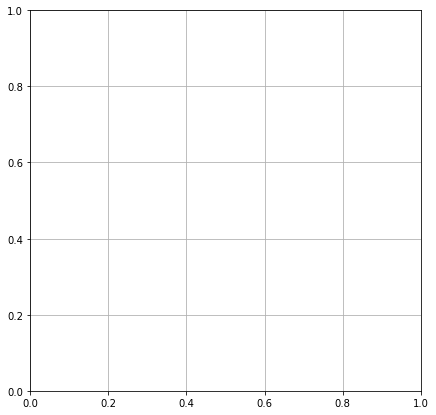

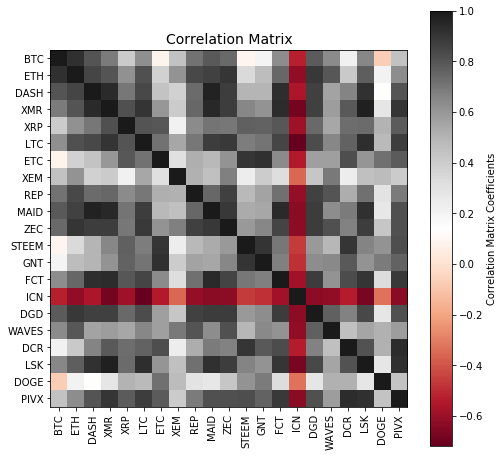

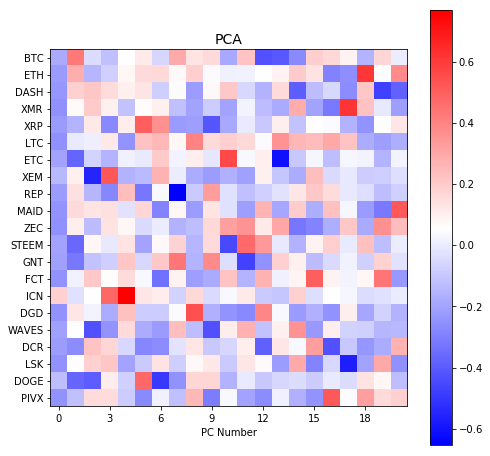

In [12]:
m = dfP.mean(axis=0)
s = dfP.std(ddof=1, axis=0)
 
# normalised time-series as an input for PCA
dfPort = (dfP - m)/s
 
c = np.cov(dfPort.values.T)     # covariance matrix
co = np.corrcoef(dfP.values.T)  # correlation matrix
 
tickers = list(dfP.columns)
 
plt.figure(figsize=(8,8))
plt.imshow(co, cmap="RdGy", interpolation="nearest")
cb = plt.colorbar()
cb.set_label("Correlation Matrix Coefficients")
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(np.arange(len(tickers)), tickers, rotation=90)
plt.yticks(np.arange(len(tickers)), tickers)
 
# perform PCA
w, v = np.linalg.eig(c)  
 
ax = plt.figure(figsize=(8,8)).gca()
plt.imshow(v, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

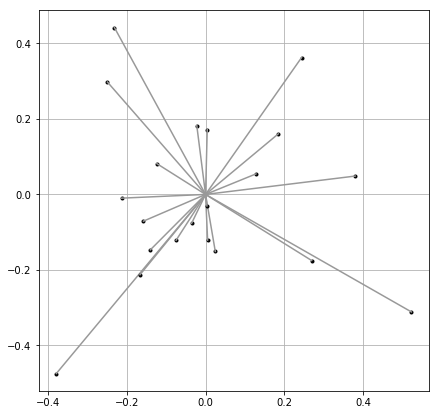

In [13]:
from matplotlib import pyplot as plt

# choose PC-k numbers
k1 = -1  # the last PC column in 'v' PCA matrix
k2 = -2  # the second last PC column
 
# begin constructing bi-plot for PC(k1) and PC(k2)
# loadings
plt.figure(figsize=(7,7))
plt.grid()

# compute the distance from (0,0) point
dist = []
for i in range(v.shape[0]):
    x = v[i,k1]
    y = v[i,k2]
    plt.plot(x, y, '.k')
    plt.plot([0,x], [0,y], '-', color=grey)
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
plt.show() 

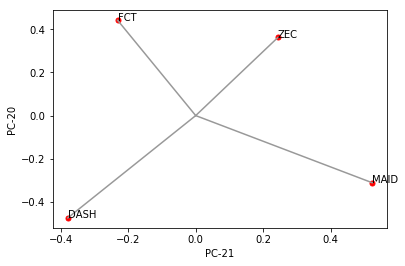

In [14]:
# check and save membership of a coin to
# a quarter number 1, 2, 3 or 4 on the plane
quar = []
for i in range(v.shape[0]):
    x = v[i,k1]
    y = v[i,k2]
    d = np.sqrt(x**2 + y**2)
    if(d > np.mean(dist) + np.std(dist, ddof=1)):
        plt.plot(x, y, '.r', markersize=10)
        plt.plot([0,x], [0,y], '-', color=grey)
        if((x > 0) and (y > 0)):
            quar.append((i, 1))
        elif((x < 0) and (y > 0)):
            quar.append((i, 2))
        elif((x < 0) and (y < 0)):
            quar.append((i, 3))
        elif((x > 0) and (y < 0)):
            quar.append((i, 4))
        plt.text(x, y, tickers[i], color='k')
 
plt.xlabel("PC-" + str(len(tickers)+k1+1))
plt.ylabel("PC-" + str(len(tickers)+k2+1))
plt.show() 

ZEC DASH
0.877140417662 9.59298546594e-11
0.729032258065 8.32288038816e-09


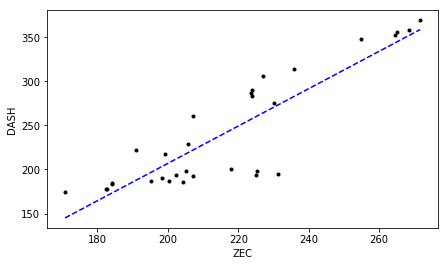

FCT MAID
0.940052454356 4.39542238078e-15
0.686021505376 5.89830554001e-08


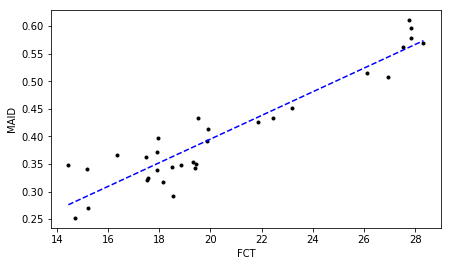

In [15]:
for i in range(len(quar)):
    # Q1 vs Q3
    if(quar[i][1] == 1):
        for j in range(len(quar)):
            if(quar[j][1] == 3):
                plt.figure(figsize=(7,4))
 
                # highly correlated coins according to the PC analysis
                print(tickers[quar[i][0]], tickers[quar[j][0]])
 
                ts1 = dfP[tickers[quar[i][0]]]  # time-series
                ts2 = dfP[tickers[quar[j][0]]]
 
                # correlation metrics and their p_values
                slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
                ktau, kpvalue = stats.kendalltau(ts1, ts2)
                print(r2, pvalue)
                print(ktau, kpvalue)
 
                plt.plot(ts1, ts2, '.k')
                xline = np.linspace(np.min(ts1), np.max(ts1), 100)
                yline = slope*xline + intercept
                plt.plot(xline, yline,'--', color='b')  # linear model fit
                plt.xlabel(tickers[quar[i][0]])
                plt.ylabel(tickers[quar[j][0]])
                plt.show()
    # Q2 vs Q4
    if(quar[i][1] == 2):
        for j in range(len(quar)):
            if(quar[j][1] == 4):
                plt.figure(figsize=(7,4))
                print(tickers[quar[i][0]], tickers[quar[j][0]])
                ts1 = dfP[tickers[quar[i][0]]]
                ts2 = dfP[tickers[quar[j][0]]]
                slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
                ktau, kpvalue = stats.kendalltau(ts1, ts2)
                print(r2, pvalue)
                print(ktau, kpvalue)
                plt.plot(ts1, ts2, '.k')
                xline = np.linspace(np.min(ts1), np.max(ts1), 100)
                yline = slope*xline + intercept
                plt.plot(xline, yline,'--', color='b')
                plt.xlabel(tickers[quar[i][0]])
                plt.ylabel(tickers[quar[j][0]])
                plt.show()